# CAPM on 12 Industry Portfolios

In [ ]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

START_DATE = '1926-01'
END_DATE = '2025-09'

factors_raw = pdr.DataReader('F-F_Research_Data_Factors', 'famafrench', start=START_DATE, end=END_DATE)
ports_raw = pdr.DataReader('12_Industry_Portfolios', 'famafrench', start=START_DATE, end=END_DATE)

In [ ]:
facs = factors_raw[0]/100
ports = ports_raw[0]/100
rx = ports.sub(facs['RF'],axis=0)

In [ ]:
betas = pd.Series(index=rx.columns, dtype=float)
alphas = pd.Series(index=rx.columns, dtype=float)
for col in rx.columns:
    y = rx[col].dropna()
    X = facs.loc[y.index, 'Mkt-RF']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    betas[col] = model.params['Mkt-RF']
    alphas[col] = model.params['const']


# Timeseries

Consider the variation of return data against the MKT factor.

Note that this is a time-series plot.

/var/folders/zx/3v_qt0957xzg3nqtnkv007d00000gn/T/ipykernel_86032/2851721156.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', rx.shape[1])


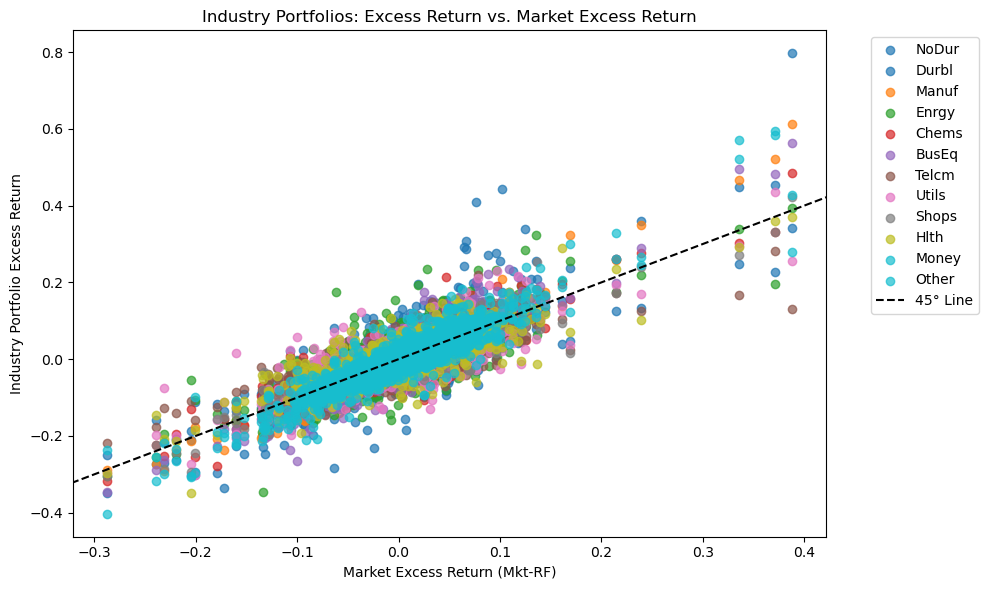

In [ ]:
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', rx.shape[1])

for idx, col in enumerate(rx.columns):
    plt.scatter(facs['Mkt-RF'], rx[col], label=col, color=colors(idx), alpha=0.7)

# Add a black dashed 45-degree line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
lim_min = min(xlim[0], ylim[0])
lim_max = max(xlim[1], ylim[1])
plt.plot([lim_min, lim_max], [lim_min, lim_max], 'k--', label="45° Line")
plt.xlim(xlim)
plt.ylim(ylim)

plt.xlabel('Market Excess Return (Mkt-RF)')
plt.ylabel('Industry Portfolio Excess Return')
plt.title('Industry Portfolios: Excess Return vs. Market Excess Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Time-series Regression

Fit a time-series regression for each industry portfolio.

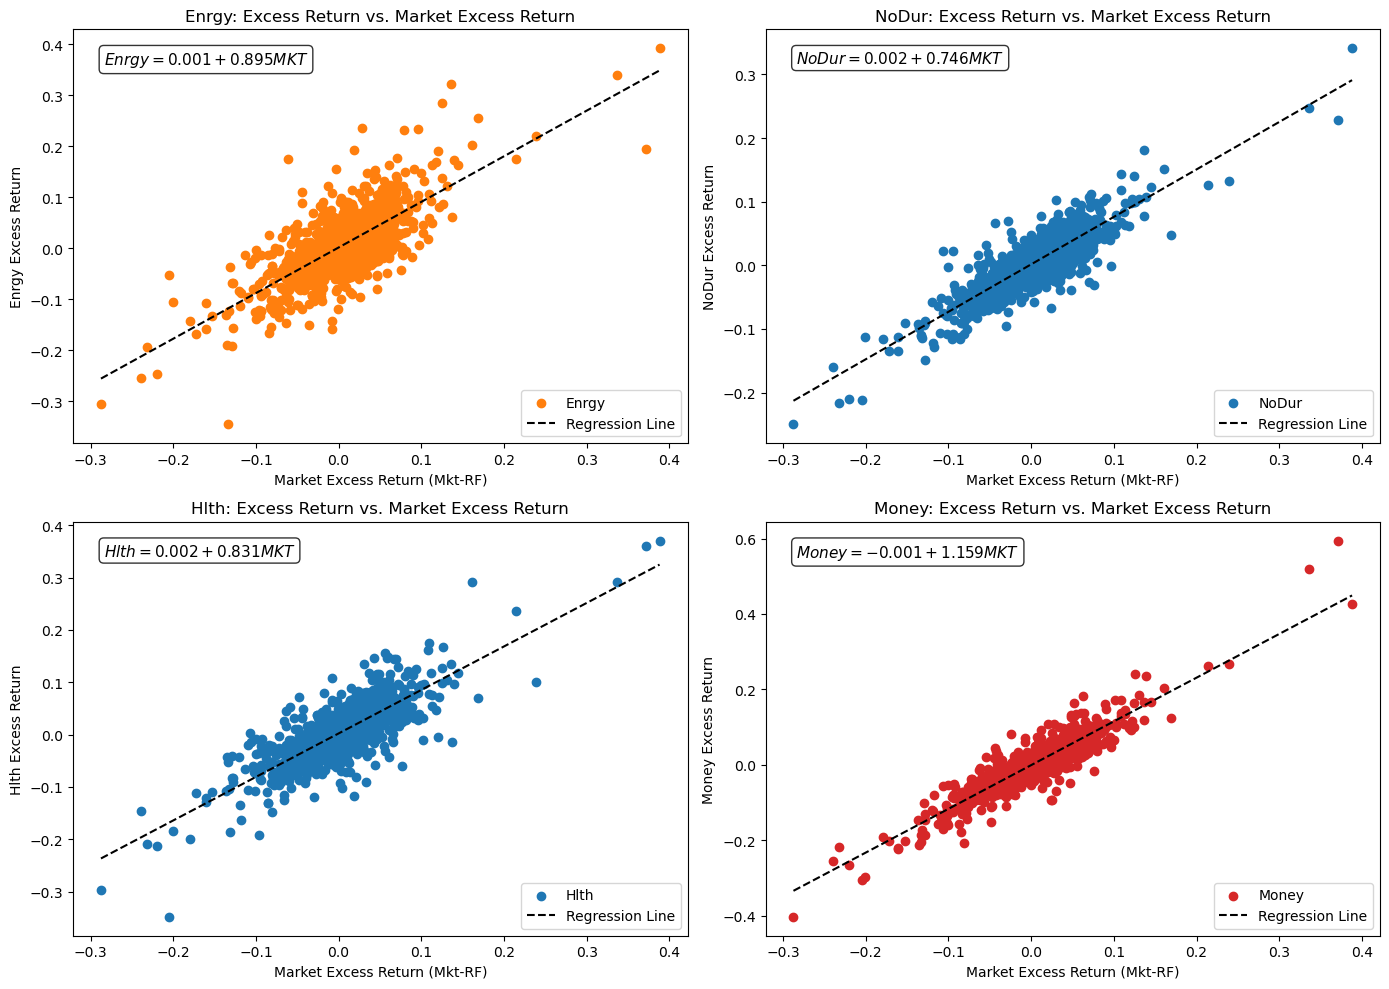

In [ ]:
# Plot regression lines and scatter plots for 4 selected industries in a 2x2 grid

selected_cols = ["Enrgy", "NoDur", "Hlth", "Money"]
colors_map = {
    "Enrgy": "tab:orange",
    "NoDur": "tab:blue",
    "Health": "tab:green",
    "Money": "tab:red"
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(selected_cols):
    ax = axes[i]
    beta = betas[col]
    alpha = alphas[col]
    y = rx[col].dropna()
    X = facs.loc[y.index, 'Mkt-RF']
    ax.scatter(X, y, color=colors_map.get(col, None), label=col)
    x_vals = np.linspace(facs['Mkt-RF'].min(), facs['Mkt-RF'].max(), 100)
    y_fit = alpha + beta * x_vals
    ax.plot(x_vals, y_fit, color='black', linestyle='--', label='Regression Line')
    eqn_text = f"${col} = {alpha:.3f} + {beta:.3f} MKT$"
    ax.annotate(eqn_text,
                xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=11,
                ha='left', va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.set_xlabel('Market Excess Return (Mkt-RF)')
    ax.set_ylabel(f'{col} Excess Return')
    ax.set_title(f'{col}: Excess Return vs. Market Excess Return')
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
rx_avg = rx.mean() * 12

y_cs = rx_avg.values
x_cs = betas.values.reshape(-1, 1)

# Without intercept: E[R] = lambda * beta
model_noi = sm.OLS(y_cs, x_cs).fit()
lambda_noi = model_noi.params.item()

# With intercept: E[R] = gamma + lambda * beta
X_with_const = sm.add_constant(x_cs)
model_i = sm.OLS(y_cs, X_with_const).fit()
alpha_i, lambda_i = model_i.params.tolist()

# The Cross-Section

The CAPM makes no claim about the goodness of fit of the time-series regressions. Rather, it implies that the cross-sectional regressions should fit perfectly.

### Other considerations

CAPM implies...
* Time-series intercept (alpha) is zero
* Cross-sectional fit (r-squared) is high
* Cross-sectional slope (lambda) is the market factor premium
* Cross-sectional intercept (gamma) is zero

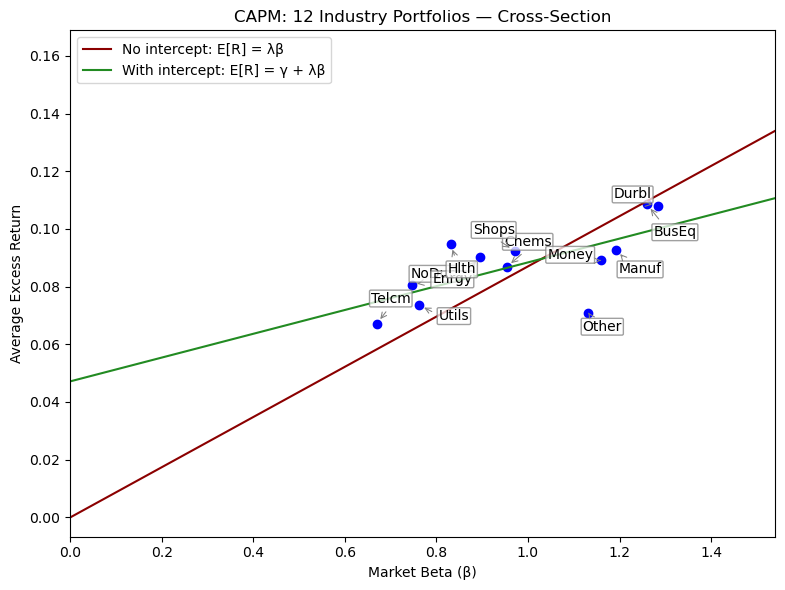

In [ ]:
FIG_MAX_SCALE = 1.2

# Scatter plot
fig = plt.figure(figsize=(8, 6))
plt.scatter(betas.values, rx_avg.values, color="blue")

# Improved annotation dispersion to reduce overlap/readability issues
offsets = [
    (15, 8), (-18, 8), (17, -14), (-20, -16), (15, 18), (20, -20), (10, 18), 
    (25, -8), (-15, 15), (8, -18), (-22, 4), (10, -10)
]
for idx, (name, b) in enumerate(betas.items()):
    offset = offsets[idx % len(offsets)]  # Cycle offsets if >12 industries
    plt.annotate(
        name, 
        (b, rx_avg[name]), 
        textcoords='offset points', 
        xytext=offset, 
        ha='center', va='center', 
        bbox=dict(boxstyle="round,pad=0.1", edgecolor='grey', facecolor='white', alpha=0.75), 
        arrowprops=dict(arrowstyle="->", color='grey', lw=0.75, relpos=(0.5,0), shrinkA=4, shrinkB=4)
    )

plt.xlabel('Market Beta (β)')
plt.ylabel('Average Excess Return')
plt.title('CAPM: 12 Industry Portfolios — Cross-Section')

x_min = 0
x_max = betas.max() * FIG_MAX_SCALE
xgrid = np.linspace(x_min, x_max, 200)
y_noi = (lambda_noi * xgrid)
y_i = (alpha_i + lambda_i * xgrid)

plt.plot(xgrid, y_noi, color="darkred", label='No intercept: E[R] = λβ')
plt.plot(xgrid, y_i, color="forestgreen", label='With intercept: E[R] = γ + λβ')
plt.legend(loc='upper left')
plt.tight_layout()

# Set plot coordinates to match full view including lines
ylim = plt.ylim()
plt.xlim(left=0, right=x_max)
plt.ylim(bottom=min(0, ylim[0]), top=max(ylim[1]*FIG_MAX_SCALE, y_i.max()*FIG_MAX_SCALE, y_noi.max()*FIG_MAX_SCALE))

plt.show()

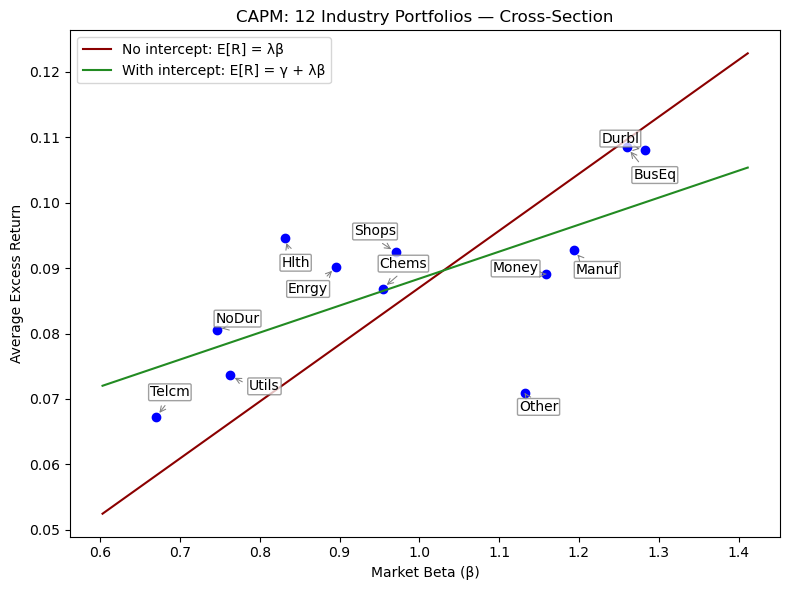

In [ ]:
FIG_MIN_SCALE = 0.9
FIG_MAX_SCALE = 1.1

# Scatter plot
fig = plt.figure(figsize=(8, 6))
plt.scatter(betas.values, rx_avg.values, color="blue")

# Improved annotation dispersion to reduce overlap/readability issues
offsets = [
    (15, 8), (-18, 8), (17, -14), (-20, -16), (15, 18), (20, -20), (10, 18), 
    (25, -8), (-15, 15), (8, -18), (-22, 4), (10, -10)
]
for idx, (name, b) in enumerate(betas.items()):
    offset = offsets[idx % len(offsets)]  # Cycle offsets if >12 industries
    plt.annotate(
        name, 
        (b, rx_avg[name]), 
        textcoords='offset points', 
        xytext=offset, 
        ha='center', va='center', 
        bbox=dict(boxstyle="round,pad=0.1", edgecolor='grey', facecolor='white', alpha=0.75), 
        arrowprops=dict(arrowstyle="->", color='grey', lw=0.75, relpos=(0.5,0), shrinkA=4, shrinkB=4)
    )

plt.xlabel('Market Beta (β)')
plt.ylabel('Average Excess Return')
plt.title('CAPM: 12 Industry Portfolios — Cross-Section')

x_min = betas.min() * FIG_MIN_SCALE
x_max = betas.max() * FIG_MAX_SCALE
xgrid = np.linspace(x_min, x_max, 200)
y_noi = (lambda_noi * xgrid)
y_i = (alpha_i + lambda_i * xgrid)

plt.plot(xgrid, y_noi, color="darkred", label='No intercept: E[R] = λβ')
plt.plot(xgrid, y_i, color="forestgreen", label='With intercept: E[R] = γ + λβ')
plt.legend(loc='upper left')
plt.tight_layout()